<a href="https://colab.research.google.com/github/enzocatorano/deep_learning_practicas/blob/master/6_GNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica: Redes en Grafos

## Clasificación de Artículos Científicos: El Dataset Cora

El dataset Cora es un conjunto de datos utilizado para la clasificación de nodos en grafos. Consiste en trabajos científicos, donde cada nodo representa un artículo y los bordes representan relaciones de citación entre ellos. Cada nodo tiene características basadas en el contenido de las palabras clave del artículo, y los nodos están etiquetados según el área de investigación del artículo.

El dataset Cora contiene publicaciones científicas clasificadas en **siete** clases diferentes, que representan áreas de investigación en aprendizaje automático. Estas clases son:

1.  **Case\_Based**
2.  **Genetic\_Algorithms**
3.  **Neural\_Networks**
4.  **Probabilistic\_Methods**
5.  **Reinforcement\_Learning**
6.  **Rule\_Learning**
7.  **Theory**

Más datos sobre el dataset en:

https://arxiv.org/abs/1603.08861


### **Es necesario instalar geometric:**

In [ ]:
# Instalando pytoch geometric en Colab
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 64.1 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 39.9 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 13.5 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.8 MB/s eta 0:00:00


## **Importar bibliotecas y bajar el dataset**

In [ ]:
# Importamos bibliotecas
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, ChebConv
import torch.nn.functional as F

In [ ]:
# Cargamos el dataset
dataset = Planetoid(root='tmp/Cora', name='Cora')

# El dataset Cora es un solo grafo
data = dataset[0]

Processing...
Done!


In [ ]:
# Veamos las propiedades del grafo
print(f'Número de nodos: {data.num_nodes}')
print(f'Número de aristas: {data.num_edges}')
print(f'Número de características de los nodos: {dataset.num_node_features}')
print(f'Número de clases: {dataset.num_classes}')
print(f'¿Es dirigido?: {data.is_directed()}')
print(f'¿Tiene auto-bucles?: {data.has_self_loops()}')
print(f'Forma de las características de los nodos (x): {data.x.shape}')
print(f'Forma de los índices de los bordes (edge_index): {data.edge_index.shape}')
print(f'Forma de las etiquetas de los nodos (y): {data.y.shape}')
print(data)

Número de nodos: 2708
Número de aristas: 10556
Número de características de los nodos: 1433
Número de clases: 7
¿Es dirigido?: False
¿Tiene auto-bucles?: False
Forma de las características de los nodos (x): torch.Size([2708, 1433])
Forma de los índices de los bordes (edge_index): torch.Size([2, 10556])
Forma de las etiquetas de los nodos (y): torch.Size([2708])
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


### **Máscaras de Train, Val y Test**

In [ ]:
# Para acceder a los conjuntos de train, validation y test usamos máscaras que cubren parte del grafo
# Veamos cuantos elementos tenemos:
print(data.train_mask.sum().item())
print(data.val_mask.sum().item())
print(data.test_mask.sum().item())

140
500
1000


¿De dónde sale ese split? Buscar en la documentación:

https://pytorch-geometric.readthedocs.io/en/2.6.0/generated/torch_geometric.datasets.Planetoid.html#torch_geometric.datasets.Planetoid

Es el predeterminado para la clase Planetoid. En la documentacion muestra:

`class Planetoid( ... , split: str = 'public', ... )`
* split (str, optional) –
    ... If set to "public", the split will be the public fixed split from the “Revisiting Semi-Supervised Learning with Graph Embeddings” paper ...

## **Creando la red**

Definir una red neuronal de dos capas convolucionales con 16 features en la capa intermedia.

Probar con capas GCNConv y ChebConv (con K =3)

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_hidden_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, num_hidden_features)
        self.conv2 = GCNConv(num_hidden_features, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)


class ChebNet(torch.nn.Module):
    def __init__(self, num_node_features, num_hidden_features, num_classes):
        super(ChebNet, self).__init__()
        self.conv1 = ChebConv(num_node_features, num_hidden_features, K=3)
        self.conv2 = ChebConv(num_hidden_features, num_classes, K=3)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

## Pruebo GCN

In [ ]:
# Inicializar el modelo
num_hidden_features = 16
model = GCN(num_node_features=dataset.num_node_features, num_hidden_features = num_hidden_features, num_classes=dataset.num_classes)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.NLLLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Tenemos que restringir la evaluación a un subconjunto de los nodos (train, val, test), definidos por la máscara
@torch.no_grad()
def evaluate(mask):
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    correct = (pred[mask] == data.y[mask]).sum()
    acc = int(correct) / int(mask.sum())
    return acc, pred


# Entrenamiento
best_val_acc = 0
best_epoch = 0
best_model_sd = model.state_dict()

for epoch in range(200):
    loss = train()
    val_acc, _ = evaluate(data.val_mask)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
        best_model_sd = model.state_dict()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch+1:03d}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}')

# Nos quedamos con el mejor modelo
model.load_state_dict(best_model_sd)
test_acc, _ = evaluate(data.test_mask)
print(f'Best Epoch: {best_epoch}')
print(f'Test Accuracy: {test_acc:.4f}')

Epoch: 001, Loss: 0.0066, Val Acc: 0.7780
Epoch: 011, Loss: 0.0063, Val Acc: 0.7760
Epoch: 021, Loss: 0.0066, Val Acc: 0.7780
Epoch: 031, Loss: 0.0066, Val Acc: 0.7780
Epoch: 041, Loss: 0.0067, Val Acc: 0.7800
Epoch: 051, Loss: 0.0066, Val Acc: 0.7780
Epoch: 061, Loss: 0.0066, Val Acc: 0.7800
Epoch: 071, Loss: 0.0066, Val Acc: 0.7780
Epoch: 081, Loss: 0.0066, Val Acc: 0.7800
Epoch: 091, Loss: 0.0066, Val Acc: 0.7780
Epoch: 101, Loss: 0.0066, Val Acc: 0.7780
Epoch: 111, Loss: 0.0066, Val Acc: 0.7800
Epoch: 121, Loss: 0.0066, Val Acc: 0.7780
Epoch: 131, Loss: 0.0066, Val Acc: 0.7780
Epoch: 141, Loss: 0.0066, Val Acc: 0.7780
Epoch: 151, Loss: 0.0066, Val Acc: 0.7780
Epoch: 161, Loss: 0.0066, Val Acc: 0.7780
Epoch: 171, Loss: 0.0066, Val Acc: 0.7780
Epoch: 181, Loss: 0.0066, Val Acc: 0.7780
Epoch: 191, Loss: 0.0066, Val Acc: 0.7780
Best Epoch: 6
Test Accuracy: 0.8080


### Calcular la matriz de confusión sobre los datos de test

<Axes: >

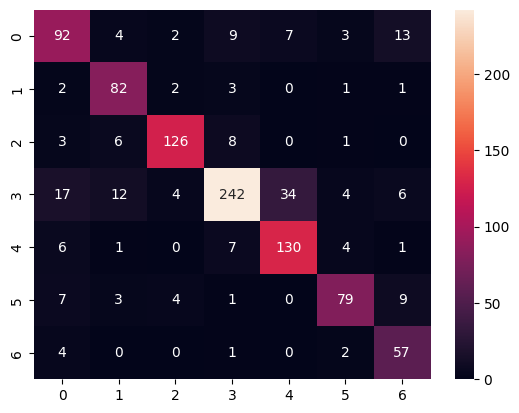

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predecimos
model.eval()
with torch.no_grad():
    _ , pred = evaluate(data.test_mask)

# Nos quedamos con valores verdaderos y predicciones solo para el conjunto de test
true_labels = data.y[data.test_mask].cpu().numpy()
predicted_labels = pred[data.test_mask].cpu().numpy()

# Calculamos la matriz de confusion
cm = confusion_matrix(true_labels, predicted_labels)

sns.heatmap(cm, annot=True, fmt='d')

## Pruebo ChebNet

In [ ]:
# Inicializar el modelo
num_hidden_features = 16
model = ChebNet(num_node_features=dataset.num_node_features, num_hidden_features = num_hidden_features, num_classes=dataset.num_classes)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.NLLLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Tenemos que restringir la evaluación a un subconjunto de los nodos (train, val, test), definidos por la máscara
@torch.no_grad()
def evaluate(mask):
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    correct = (pred[mask] == data.y[mask]).sum()
    acc = int(correct) / int(mask.sum())
    return acc, pred


# Entrenamiento
best_val_acc = 0
best_epoch = 0
best_model_sd = model.state_dict()

for epoch in range(200):
    loss = train()
    val_acc, _ = evaluate(data.val_mask)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
        best_model_sd = model.state_dict()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch+1:03d}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}')

# Nos quedamos con el mejor modelo
model.load_state_dict(best_model_sd)
test_acc, _ = evaluate(data.test_mask)
print(f'Best Epoch: {best_epoch}')
print(f'Test Accuracy: {test_acc:.4f}')

Epoch: 001, Loss: 1.9771, Val Acc: 0.3200
Epoch: 011, Loss: 0.0046, Val Acc: 0.6300
Epoch: 021, Loss: 0.0002, Val Acc: 0.5940
Epoch: 031, Loss: 0.0001, Val Acc: 0.5900
Epoch: 041, Loss: 0.0001, Val Acc: 0.5960
Epoch: 051, Loss: 0.0003, Val Acc: 0.6180
Epoch: 061, Loss: 0.0006, Val Acc: 0.6500
Epoch: 071, Loss: 0.0011, Val Acc: 0.6700
Epoch: 081, Loss: 0.0019, Val Acc: 0.6780
Epoch: 091, Loss: 0.0025, Val Acc: 0.6780
Epoch: 101, Loss: 0.0028, Val Acc: 0.6820
Epoch: 111, Loss: 0.0028, Val Acc: 0.6860
Epoch: 121, Loss: 0.0028, Val Acc: 0.6900
Epoch: 131, Loss: 0.0028, Val Acc: 0.6980
Epoch: 141, Loss: 0.0027, Val Acc: 0.7000
Epoch: 151, Loss: 0.0027, Val Acc: 0.7020
Epoch: 161, Loss: 0.0027, Val Acc: 0.7080
Epoch: 171, Loss: 0.0026, Val Acc: 0.7120
Epoch: 181, Loss: 0.0026, Val Acc: 0.7180
Epoch: 191, Loss: 0.0026, Val Acc: 0.7140
Best Epoch: 178
Test Accuracy: 0.7560


### Calcular la matriz de confusión sobre los datos de test

<Axes: >

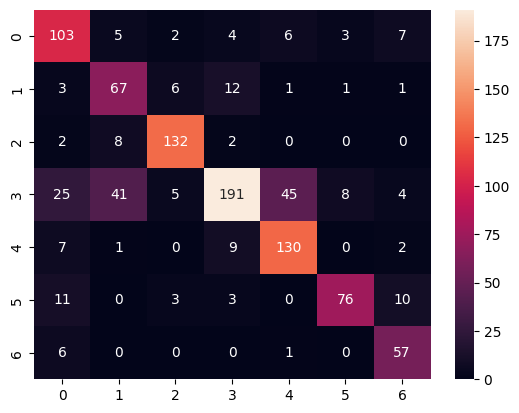

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predecimos
model.eval()
with torch.no_grad():
    _ , pred = evaluate(data.test_mask)

# Nos quedamos con valores verdaderos y predicciones solo para el conjunto de test
true_labels = data.y[data.test_mask].cpu().numpy()
predicted_labels = pred[data.test_mask].cpu().numpy()

# Calculamos la matriz de confusion
cm = confusion_matrix(true_labels, predicted_labels)

sns.heatmap(cm, annot=True, fmt='d')